In [18]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import requests

from scraper.headers import HEADERS

In [269]:
import matplotlib.pyplot as plt

# Analysis overview

The analysis will be done as a statistical simulation using the empirical election transmissions (ER) data received by the COMELEC's transparency servers.

The primary question that we want to probe is whether the seemingly constant temporal disparity between Bongbong Marcos' vs. Leni Robredo's rate of votes is a statistical anomaly. Conclusion whether cheating at any level or of any form is not covered by this analysis.

With the availability of the ER data that can be scraped from the transparency servers, we can perform statistical simulations on the actual vote counts data. The analysis will rely on some statistical assumptions:

1. That success of the transmission of a single return is independent of other transmissions.
2. The probability of success of transmission is uniform across precincts.
    - We can check the distribution of the votes for each polling precinct to see how might we improve the assumption.
    - This can be further refined and can be modeled using a more sophisticated distribution as we build better understanding of other underlying factors that affect the transmission.

The two assumptions will be embedded in the simulation as a Geometric distribution modeling the transmission time of each precinct after the closing of the polls.

We shall build an ensemble of simulations and calculate the expected rate of votes difference between the two candidates. Using the data of the simulation, we can then compare the empirical values of the rate of votes and see if this lies within the statistical confidence interval of the modeled process.

In [4]:
RESULTS_DIR = Path("__file__").parent / "data" / "results"
assert RESULTS_DIR.exists()

In [138]:
pres_json_fname = Path("__file__").parent / "data" / "pres_json.json"

if pres_json_fname.exists():
    pres_json = json.loads(pres_json_fname.read_text())
else:
    response = requests.get("https://2022electionresults.comelec.gov.ph/data/contests/5587.json", headers=HEADERS)
    pres_json = response.json()
    pres_json_fname.write_text(json.dumps(pres_json))

data_map_president = pd.DataFrame(pres_json["bos"])

In [139]:
data_map_president["bo"] = data_map_president["boc"]
data_map_president

,boc,bon,boi,to,pc,pn,pcc,pcy,pcm,pck,bo
0,46446,"PACQUIAO, MANNY PACMAN(PROMDI)",46438.png,9,279,ABAG PROMDI,1,1,1,1,46446
1,46440,"DOMAGOSO, ISKO MORENO (AKSYON)",46441.png,3,281,AKSYON DEMOKRATIKO,1,1,1,1,46440
2,46445,"MONTEMAYOR, JOSE JR. (DPP)",46439.png,8,288,DEMOCRATIC PARTY OF THE PHILIPPINES,1,1,1,1,46445
3,46443,"MANGONDATO, FAISAL (KTPNAN)",46440.png,6,290,KATIPUNAN NG KAMALAYANG KAYUMANGGI,1,1,1,1,46443
4,46441,"GONZALES, NORBERTO (PDSP)",46444.png,4,299,PARTIDO DEMOKRATIKO SOSYALISTA NG PILIPINAS,1,1,1,1,46441
5,46439,"DE GUZMAN, LEODY (PLM)",46445.png,2,300,PARTIDO LAKAS NG MASA,1,1,1,1,46439
6,46442,"LACSON, PING (PDR)",46443.png,5,301,PARTIDO PARA SA DEMOKRATIKONG REPORMA,1,1,1,1,46442
7,46438,"ABELLA, ERNIE (IND)",46447.png,1,343,INDEPENDENT,1,1,1,1,46438
8,46447,"ROBREDO, LENI (IND)",46446.png,10,343,INDEPENDENT,1,1,1,1,46447
9,46444,"MARCOS, BONGBONG (PFP)",46442.png,7,345,PARTIDO FEDERAL NG PILIPINAS,1,1,1,1,46444


In [249]:
results_files = list(RESULTS_DIR.glob("*/*.json"))
len(results_files)

48966

In [250]:
p = 0.12
rvs = np.random.geometric(p, size=len(results_files))
print(pd.Series(rvs).describe())

fields = ["bo", "v", "tot", "per", "ser", "bon", "pc", "pn"]

batch = {rv: [] for rv in rvs}

for rv, rf in zip(rvs, results_files):
    d = json.loads(rf.read_text())
    d = pd.DataFrame(d["rs"])
    pres = d[d["cc"] == 5587]
    pres = pres.merge(data_map_president, on="bo", how="left")

    batch[rv].append(pres[fields])

count    48966.000000
mean         8.367949
std          7.862886
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max         87.000000
dtype: float64


In [251]:
rv_data = []

for rv in sorted(batch.keys()):
    b = pd.concat(batch[rv])
    b = b.groupby("bon")["v"].sum()

    db = dict(
        count=len(batch[rv]),
        hour=rv,
        total=b.sum()
    )
    db.update(b.to_dict())
    rv_data.append(db)

rv_data = pd.DataFrame(rv_data).set_index(["hour", "count"])
rv_data

,,total,"ABELLA, ERNIE (IND)","DE GUZMAN, LEODY (PLM)","DOMAGOSO, ISKO MORENO (AKSYON)","GONZALES, NORBERTO (PDSP)","LACSON, PING (PDR)","MANGONDATO, FAISAL (KTPNAN)","MARCOS, BONGBONG (PFP)","MONTEMAYOR, JOSE JR. (DPP)","PACQUIAO, MANNY PACMAN(PROMDI)","ROBREDO, LENI (IND)"
hour,count,,,,,,,,,,,
1,5957,2953078,7408,5458,81237,5440,40832,2863,1646073,3402,187593,972772
2,5072,2505153,6436,4692,67675,4495,33970,2381,1404668,2939,165206,812691
3,4580,2269366,5729,4233,60480,4103,30947,2214,1267610,2600,145463,745987
4,3969,1974616,4950,3664,52388,3466,26961,1692,1111869,2355,123820,643451
5,3544,1747284,4436,3211,46288,3283,23642,1453,993374,2014,110181,559402
...,...,...,...,...,...,...,...,...,...,...,...,...
74,1,373,0,1,7,1,5,0,310,0,6,43
81,1,707,1,1,51,2,8,1,466,0,30,147
83,1,380,1,1,7,1,13,0,294,0,4,59


In [252]:
sub_data = rv_data[["MARCOS, BONGBONG (PFP)", "ROBREDO, LENI (IND)"]].copy()
sub_data

,,"MARCOS, BONGBONG (PFP)","ROBREDO, LENI (IND)"
hour,count,,
1,5957,1646073,972772
2,5072,1404668,812691
3,4580,1267610,745987
4,3969,1111869,643451
5,3544,993374,559402
...,...,...,...
74,1,310,43
81,1,466,147
83,1,294,59


In [253]:
sub_data.divide(sub_data.sum(axis=1), axis=0)

,,"MARCOS, BONGBONG (PFP)","ROBREDO, LENI (IND)"
hour,count,,
1,5957,0.628549,0.371451
2,5072,0.633487,0.366513
3,4580,0.629525,0.370475
4,3969,0.633428,0.366572
5,3544,0.639741,0.360259
...,...,...,...
74,1,0.878187,0.121813
81,1,0.760196,0.239804
83,1,0.832861,0.167139


In [254]:
sub_data.cumsum().divide(sub_data.cumsum().sum(axis=1), axis=0)

,,"MARCOS, BONGBONG (PFP)","ROBREDO, LENI (IND)"
hour,count,,
1,5957,0.628549,0.371451
2,5072,0.630813,0.369187
3,4580,0.630435,0.369565
4,3969,0.631045,0.368955
5,3544,0.632374,0.367626
...,...,...,...
74,1,0.634149,0.365851
81,1,0.634153,0.365847
83,1,0.634156,0.365844


Text(0.5, 1.0, 'Share of votes (cumulative)')

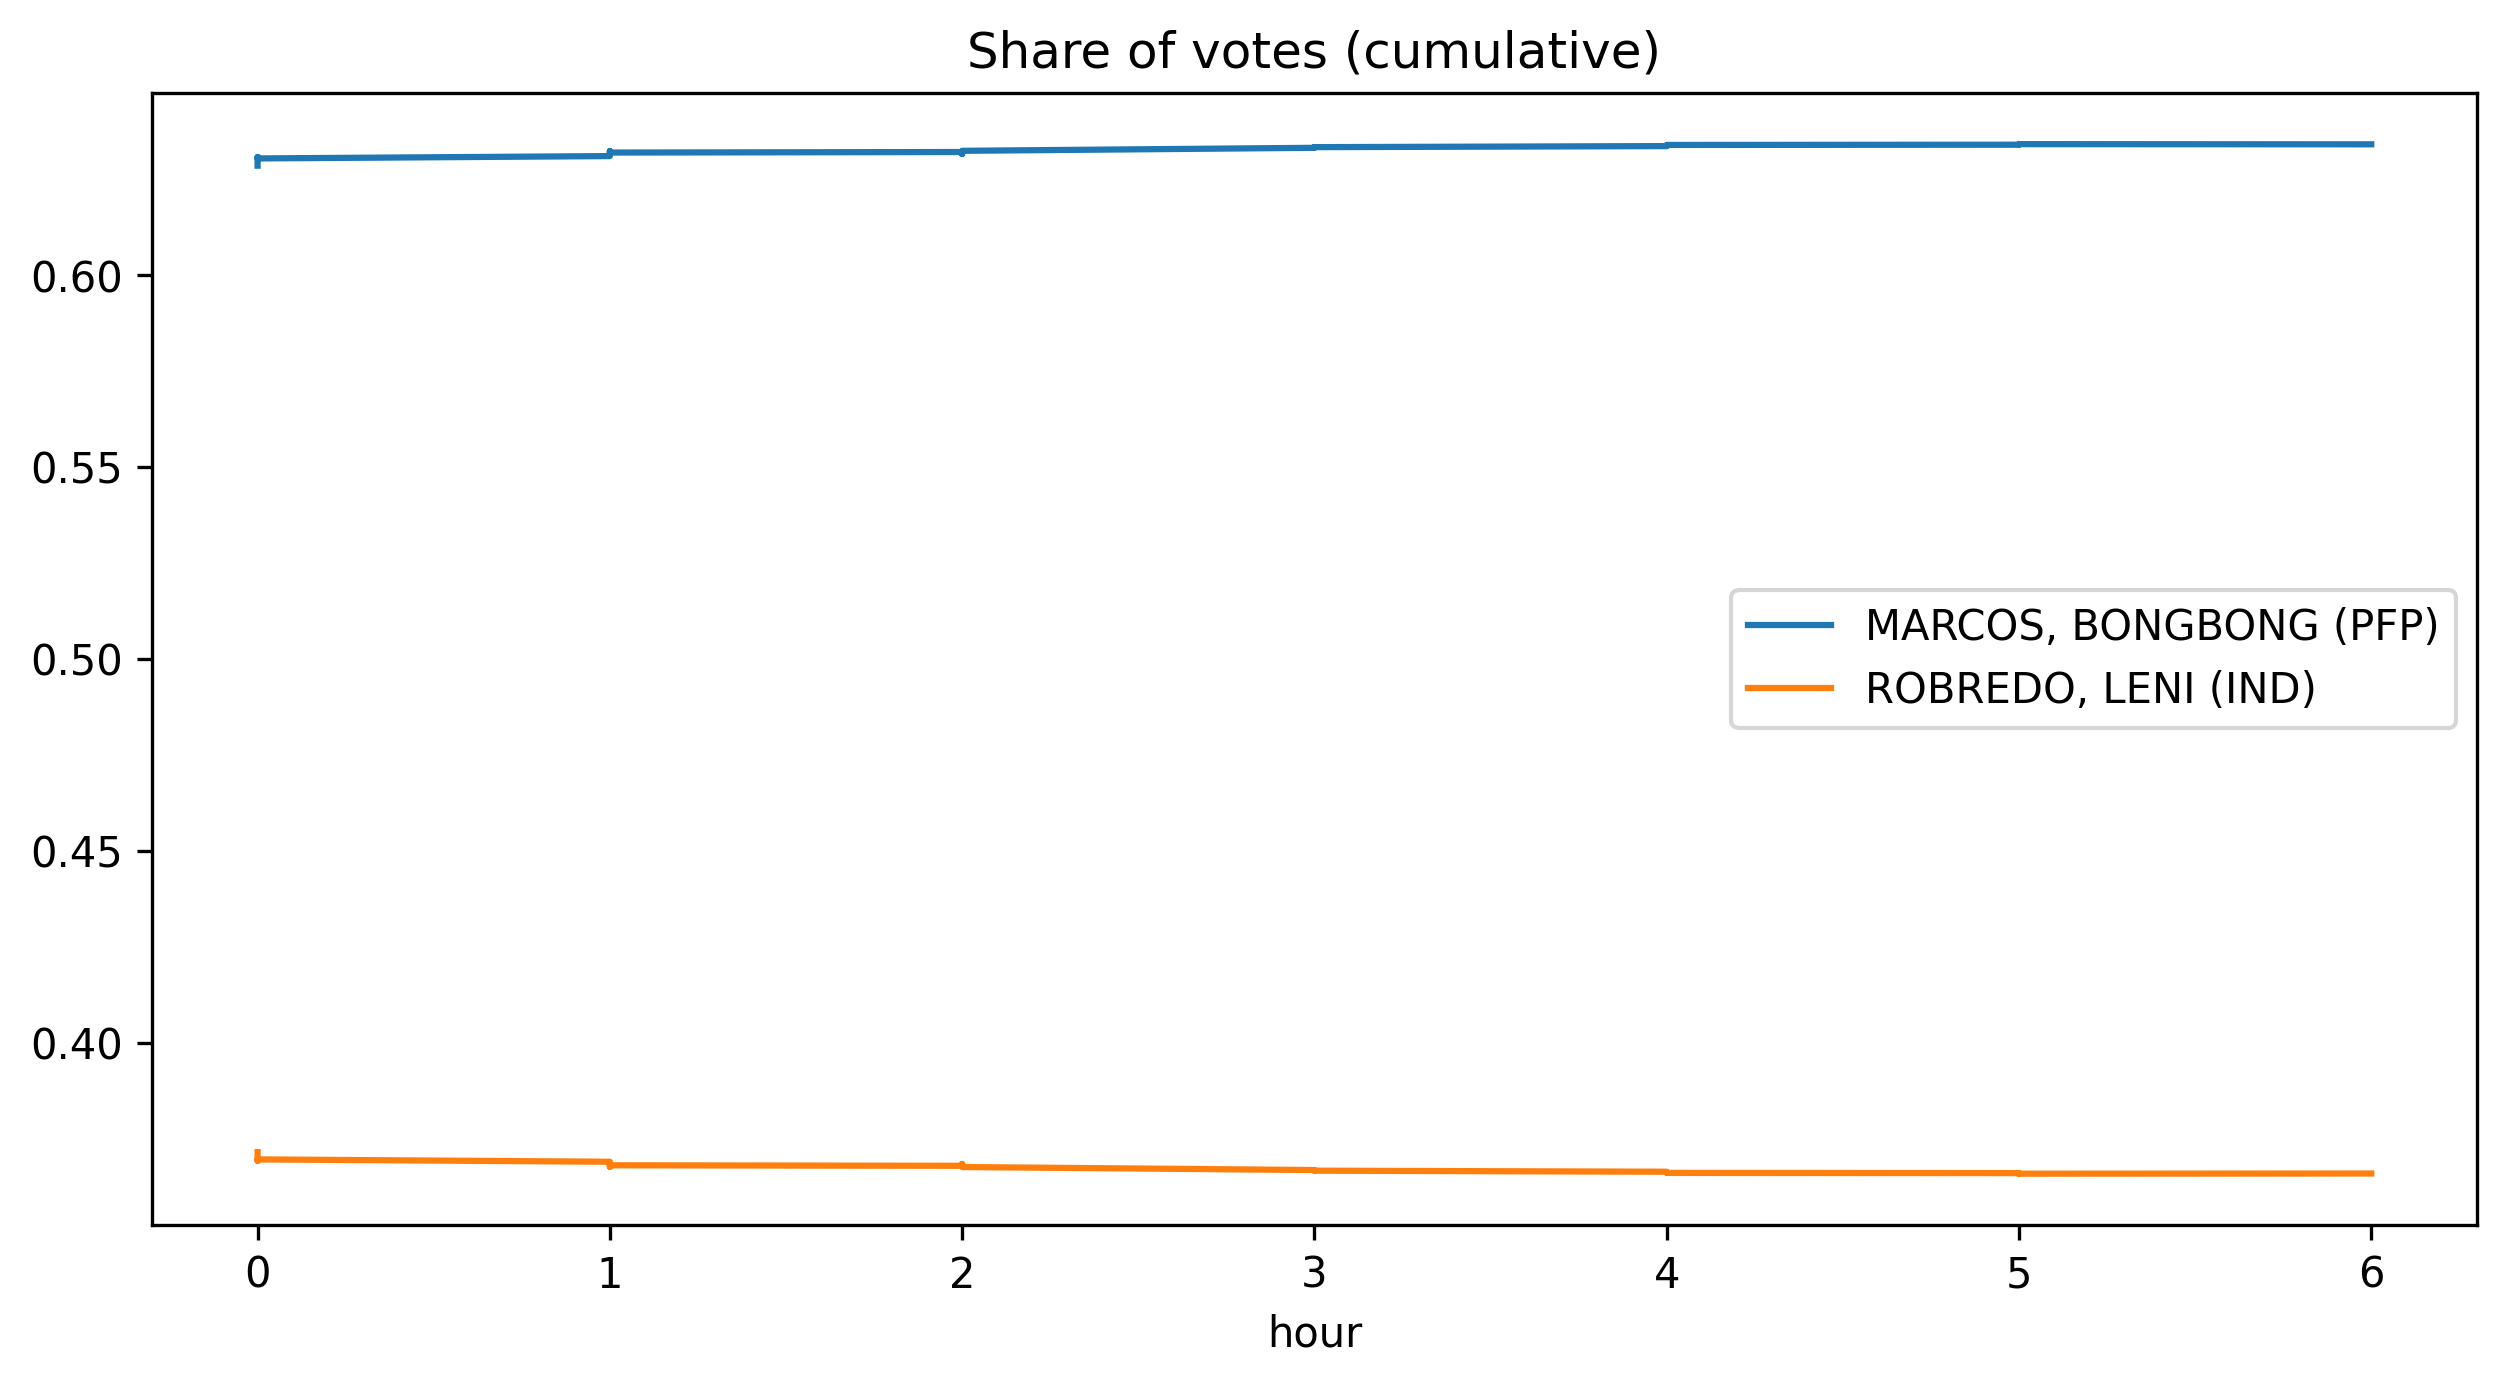

In [271]:
ss = sub_data.cumsum().divide(sub_data.cumsum().sum(axis=1), axis=0)

ss = ss.reset_index(level=1, drop="count")
ss.index = ss.index // 4

fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.gca()
ss.iloc[:4 * 6].plot(ax=ax)

ax.set_title("Share of votes (cumulative)")

In [158]:
from scipy.stats import geom

In [169]:
# ER
er_rates = pd.Series({
    202205092032: 53.50,
    202205092047: 57.77,
    202205092102: 61.05,
    202205092117: 63.77,
    202205092132: 66.09,
    202205092147: 68.27,
    202205092202: 70.27,
    202205092217: 72.09,
    202205092232: 73.91,
    202205092247: 75.64,
    202205092302: 77.32,
    202205092332: 80.39,
})

er_rates

202205092032    53.50
202205092047    57.77
202205092102    61.05
202205092117    63.77
202205092132    66.09
202205092147    68.27
202205092202    70.27
202205092217    72.09
202205092232    73.91
202205092247    75.64
202205092302    77.32
202205092332    80.39
dtype: float64

In [194]:
NUM_VB = 107785
er_counts = (er_rates * NUM_VB // 100)
er_counts

202205092032    57664.0
202205092047    62267.0
202205092102    65802.0
202205092117    68734.0
202205092132    71235.0
202205092147    73584.0
202205092202    75740.0
202205092217    77702.0
202205092232    79663.0
202205092247    81528.0
202205092302    83339.0
202205092332    86648.0
dtype: float64

In [171]:
er_counts.diff()

202205092032       NaN
202205092047    4603.0
202205092102    3535.0
202205092117    2932.0
202205092132    2501.0
202205092147    2349.0
202205092202    2156.0
202205092217    1962.0
202205092232    1961.0
202205092247    1865.0
202205092302    1811.0
202205092332    3309.0
dtype: float64

In [172]:
x = er_counts.diff()
mean = x.mean()
var = x.std()
likelihoods = {}
mean, var

(2634.909090909091, 879.4192918677023)

In [173]:
p = 1 / mean
p

0.00037951973502622135

In [174]:
likelihoods['geometric'] = x.map(lambda val: geom.pmf(val, p)).prod()

In [175]:
best_fit = max(likelihoods, key=lambda x: likelihoods[x])
print("Best fit:", best_fit)
print("Likelihood:", likelihoods[best_fit])

Best fit: geometric
Likelihood: 3.937724679004597e-43


<AxesSubplot:>

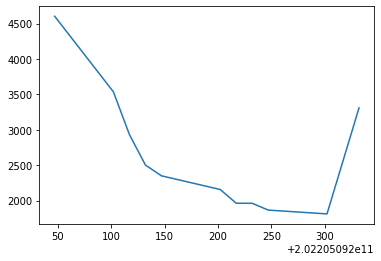

In [176]:
er_counts.diff().plot()

In [188]:
ee = er_counts.diff()[1:-1]
ee.index = list(range(1, len(ee) + 1))
ee

1     4603.0
2     3535.0
3     2932.0
4     2501.0
5     2349.0
6     2156.0
7     1962.0
8     1961.0
9     1865.0
10    1811.0
dtype: float64

<AxesSubplot:>

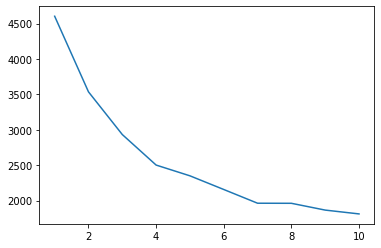

In [189]:
ee.plot()

[]

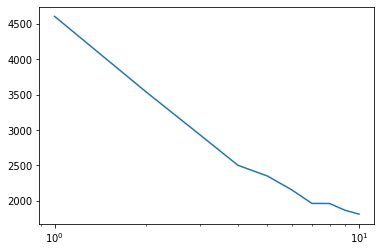

In [193]:
ee.plot().semilogx()

In [203]:
ee / np.log10(ee.index)

1              inf
2     1.174302e+04
3     6.145188e+03
4     4.154071e+03
5     3.360659e+03
6     2.770670e+03
7     2.321624e+03
8     2.171434e+03
9     1.954430e+03
10    1.811000e+03
dtype: float64

In [204]:
0.0027

370.3703703703703

In [243]:
er_rates_reindexed = er_rates.copy()
er_rates_reindexed.index = list(range(6, 6 + len(er_rates)))
er_rates_reindexed = er_rates_reindexed / 100
er_rates_reindexed

6     0.5350
7     0.5777
8     0.6105
9     0.6377
10    0.6609
11    0.6827
12    0.7027
13    0.7209
14    0.7391
15    0.7564
16    0.7732
17    0.8039
dtype: float64

<AxesSubplot:>

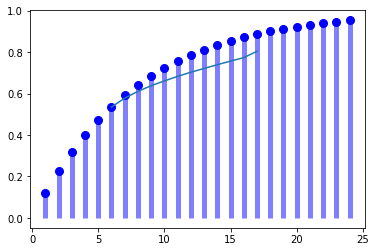

In [248]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
p = 0.12
xi = list(range(1, (6 * 4) + 1))

ax.plot(xi, geom.cdf(xi, p), 'bo', ms=8, label='geom pmf')
ax.vlines(xi, 0, geom.cdf(xi, p), colors='b', lw=5, alpha=0.5)
er_rates_reindexed.plot(ax=ax)

In [226]:
rvf = geom(p)
rvf

ValueError: x and y must have same first dimension, but have shapes (12,) and (96,)